In [ ]:
%autosave 0

# Testing non-linear solvers on the Rosenbrock function

## Problem definition

In this notebook we show how to set a user-defined objective function and minimize it using different solvers.
The function understudy is the well-known convex Rosenbrock function. Its analytical form for the 2D case takes the follwing form:
\begin{equation}
\phi(x,y) = (1-x)^2 + 100 (y-x^2)^2,
\end{equation}
in which the unique global minimum is at $x=y=1$. The global minimum is inside a long, narrow, parabolic-shaped flat valley. To find the valley is trivial. To converge to the global minimum, however, is difficult. Hence, this function represents a good testing case for any non-linear optimization scheme.

In [1]:
%load_ext autoreload
%autoreload 2
#Loading necessary modules
import sys
sys.path.insert(0, "../python")
import pyVector as Vec
import pyOperator as Op
import pyProblem as Prblm
from pyStopper import BasicStopper as Stopper
from pyStepper import ParabolicStep as StepperPar
from pyStepper import CvSrchStep as StepperMT
from pyStepper import StrongWolfe
from pyNonLinearSolver import NLCGsolver as NLCG
from pyNonLinearSolver import LBFGSsolver as LBFGS
from pyNonLinearSolver import LBFGSBsolver as LBFGSB
import numpy as np
#Plotting library
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
params = {
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 12, # was 10
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
matplotlib.rcParams.update(params)

Let's first define the problem object. Our model vector is going to be $\mathbf{m} = [x \,, \, y]^T$. Since the libary assumes that the objective function is written in terms of some residual vector (i.e., $\phi(\mathbf{r}(\mathbf{m}))$, we will create a vector containing objective function as a single scalar value. 

In [2]:
class Rosenbrock_prblm(Prblm.Problem):
	"""
	   Rosenbrock function inverse problem
	   f(x,y) = (1 - x)^2 + 100*(y -x^2)^2
	   m = [x y]'
	   res = objective function value
	"""

	def __init__(self,x_initial,y_initial, minBound=None, maxBound=None):
		"""Constructor of linear problem"""
		#Setting the bounds (if any)
		super(Rosenbrock_prblm,self).__init__(minBound, maxBound)
		#Setting initial model
		self.model  = Vec.vectorIC(np.array((x_initial,y_initial)))
		self.dmodel = self.model.clone()
		self.dmodel.zero()
		#Gradient vector
		self.grad=self.dmodel.clone()
		#Residual vector
		self.res = Vec.vectorIC(np.array((0.,)))
		#Dresidual vector
		self.dres=self.res.clone()
		#Setting default variables
		self.setDefaults()
		self.linear=False
		return

	def objf(self,model):
		"""Objective function computation"""
		m = model.getNdArray() #Getting ndArray of the model
		obj = self.res.arr[0]
		return obj

	def resf(self,model):
		"""Residual function"""
		m = model.getNdArray() #Getting ndArray of the model
		self.res.getNdArray()[0] = (1.0 - m[0])*(1.0 - m[0]) + 100.0 * (m[1] - m[0]*m[0]) * (m[1] - m[0]*m[0])
		return self.res

	def gradf(self,model,res):
		"""Gradient computation"""
		m = model.getNdArray() #Getting ndArray of the model
		self.grad.getNdArray()[0] = - 2.0 * (1.0 - m[0]) - 400.0 * m[0] * (m[1] - m[0]*m[0])
		self.grad.getNdArray()[1] = 200.0 * (m[1] - m[0]*m[0])
		return self.grad

	def dresf(self,model,dmodel):
		"""Linear variation of the objective function value"""
		m = model.getNdArray() #Getting ndArray of the model
		dm = dmodel.getNdArray() #Getting ndArray of the model
		self.dres.arr[0] = (- 2.0 * (1.0 - m[0]) - 400.0 * m[0] * (m[1] - m[0]*m[0]))* dm[0] + (200.0 * (m[1] - m[0]*m[0])) * dm[1]
		return self.dres

### Instantiation of the inverse problem and of the various solvers

In [3]:
#Starting point for all the optimization problem
x_init = -1.0
y_init = -1.0
#Testing solver on Rosenbrock function
Ros_prob = Rosenbrock_prblm(x_init,y_init)

Before running any inversion, let's compute the objective function for different values of $x$ and $y$. This step will be useful when we want to plot the optimization path taken by the various tested algorithms.

In [4]:
#Computing the objective function for plotting
x_samples = np.linspace(-1.5,1.5,1000)
y_samples = np.linspace(3,-1.5,1000)
obj_ros = Vec.vectorIC(np.zeros((len(x_samples),len(y_samples))))
obj_ros_np = obj_ros.getNdArray()
model_test = Vec.vectorIC(np.array((0.0,0.0)))
model_test_np = model_test.getNdArray()
for ix,x_value in enumerate(x_samples):
	for iy,y_value in enumerate(y_samples):
		model_test_np[0] = x_value
		model_test_np[1] = y_value
		obj_ros_np[ix,iy]=Ros_prob.get_obj(model_test)

First we test a non-linear conjugate-gradient method in which a parabolic stepper with three-point interpolation is used. 

In [5]:
niter = 1000
Stop  = Stopper(niter=niter,tolr=1e-32,tolg=1e-32)
NLCGsolver = NLCG(Stop, beta_type='HZ')
Ros_prob = Rosenbrock_prblm(x_init,y_init) #Resetting the problem
NLCGsolver.setDefaults(save_obj=True,save_model=True)
NLCGsolver.run(Ros_prob,verbose=True)
#Converting sampled points to arrays for plotting
x_smpld=[]
y_smpld=[]
for iter in range(len(NLCGsolver.model)):
    x_smpld.append(NLCGsolver.model[iter].getNdArray()[0])
    y_smpld.append(NLCGsolver.model[iter].getNdArray()[1])

##########################################################################################
			NON-LINEAR CONJUGATE GRADIENT SOLVER log file
	Restart folder: /scratch/users/arustam/restart_2025-04-10T17-27-33.967750/
	Conjugate method used: HZ
##########################################################################################

iter = 0000, obj = 4.04000e+02, gradnorm = 8.98e+02, feval = 1, geval = 1
iter = 0001, obj = 4.00632e+01, gradnorm = 1.33e+02, feval = 4, geval = 2
iter = 0002, obj = 3.84404e+00, gradnorm = 3.80e+01, feval = 7, geval = 3
iter = 0003, obj = 6.53600e-01, gradnorm = 1.59e+00, feval = 10, geval = 4
iter = 0004, obj = 6.35361e-01, gradnorm = 1.57e+00, feval = 13, geval = 5
iter = 0005, obj = 5.76040e-01, gradnorm = 2.23e+00, feval = 16, geval = 6
iter = 0006, obj = 5.47205e-01, gradnorm = 4.76e+00, feval = 22, geval = 7
iter = 0007, obj = 3.99569e-01, gradnorm = 8.30e+00, feval = 25, geval = 8
iter = 0008, obj = 2.65074e-01, gradnorm = 1.19e+00, feval = 28, gev

Let's plot the optimization path taken by the algorithm, which converged to the global minimum in 199 iterations using a parabolic stepper.

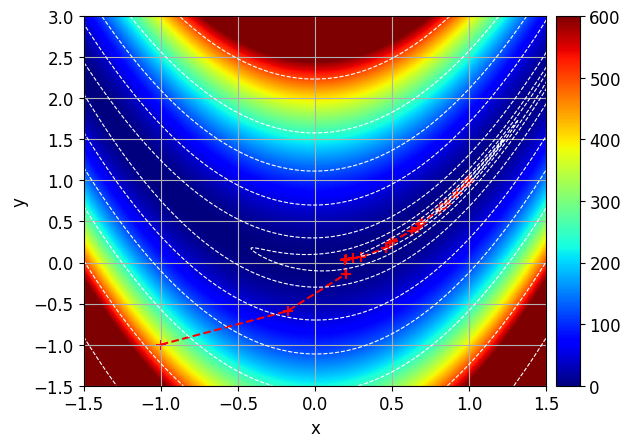

In [6]:
fig,ax=plt.subplots()
# im=plt.imshow(obj_ros_np.T,cmap='jet',vmin=0.0,vmax=600,extent=[-1.5,1.5,-1.0,3.0])
plt.scatter(x_smpld,y_smpld,color='red',s=50,marker="+")
plt.plot(x_smpld,y_smpld,"--",color='red')
im=plt.imshow(obj_ros_np.T,cmap='jet',vmin=0.0,vmax=600,extent=[1.5,-1.5,-1.5,3.0])
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
cs = plt.contour(obj_ros_np.T,levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],extent=[-1.5,1.5,3.0,-1.5],
                 colors="white",linewidths=(0.8,),linestyles=('--'))
plt.gca().invert_xaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax.set_aspect('auto')

For the second test, we will test the steppest-descent approach using the same stepper.

In [14]:
NLSDsolver = NLCG(Stop,beta_type="SD")
Ros_prob = Rosenbrock_prblm(x_init,y_init) #Resetting the problem
NLSDsolver.setDefaults(save_obj=True,save_model=True)
NLSDsolver.run(Ros_prob,verbose=True)
#Converting sampled points to arrays for plotting
x_smpld=[]
y_smpld=[]
for iter in range(len(NLSDsolver.model)):
    x_smpld.append(NLSDsolver.model[iter].getNdArray()[0])
    y_smpld.append(NLSDsolver.model[iter].getNdArray()[1])

##########################################################################################
			NON-LINEAR STEEPEST-DESCENT SOLVER log file
	Restart folder: /scratch/users/arustam/restart_2025-02-21T18-01-44.020245/
##########################################################################################

iter = 0000, obj = 4.04000e+02, gradnorm = 8.98e+02, feval = 1, geval = 1
iter = 0001, obj = 4.00632e+01, gradnorm = 1.33e+02, feval = 4, geval = 2
iter = 0002, obj = 1.38669e+00, gradnorm = 1.31e+01, feval = 7, geval = 3
iter = 0003, obj = 9.47697e-01, gradnorm = 1.97e+00, feval = 10, geval = 4
iter = 0004, obj = 9.09671e-01, gradnorm = 1.93e+00, feval = 13, geval = 5
iter = 0005, obj = 5.52153e-01, gradnorm = 8.04e+00, feval = 16, geval = 6
iter = 0006, obj = 4.41805e-01, gradnorm = 1.10e+00, feval = 23, geval = 7
iter = 0007, obj = 4.33636e-01, gradnorm = 1.09e+00, feval = 26, geval = 8
iter = 0008, obj = 4.17899e-01, gradnorm = 1.06e+00, feval = 29, geval = 9
iter = 0009, obj = 3.8

iter = 0491, obj = 2.38822e-02, resnorm = 2.39e-02, gradnorm = 1.86e-01, feval = 1478, geval = 492
iter = 0492, obj = 2.38040e-02, resnorm = 2.38e-02, gradnorm = 2.94e-01, feval = 1481, geval = 493
iter = 0493, obj = 2.37262e-02, resnorm = 2.37e-02, gradnorm = 1.85e-01, feval = 1484, geval = 494
iter = 0494, obj = 2.36486e-02, resnorm = 2.36e-02, gradnorm = 2.93e-01, feval = 1487, geval = 495
iter = 0495, obj = 2.35714e-02, resnorm = 2.36e-02, gradnorm = 1.84e-01, feval = 1490, geval = 496
iter = 0496, obj = 2.34945e-02, resnorm = 2.35e-02, gradnorm = 2.91e-01, feval = 1493, geval = 497
iter = 0497, obj = 2.34179e-02, resnorm = 2.34e-02, gradnorm = 1.84e-01, feval = 1496, geval = 498
iter = 0498, obj = 2.33417e-02, resnorm = 2.33e-02, gradnorm = 2.90e-01, feval = 1499, geval = 499
iter = 0499, obj = 2.32657e-02, resnorm = 2.33e-02, gradnorm = 1.83e-01, feval = 1502, geval = 500
iter = 0500, obj = 2.31901e-02, resnorm = 2.32e-02, gradnorm = 2.89e-01, feval = 1505, geval = 501
iter = 050

iter = 0837, obj = 8.70644e-03, resnorm = 8.71e-03, gradnorm = 1.07e-01, feval = 2516, geval = 838
iter = 0838, obj = 8.68339e-03, resnorm = 8.68e-03, gradnorm = 1.68e-01, feval = 2519, geval = 839
iter = 0839, obj = 8.66040e-03, resnorm = 8.66e-03, gradnorm = 1.06e-01, feval = 2522, geval = 840
iter = 0840, obj = 8.63749e-03, resnorm = 8.64e-03, gradnorm = 1.68e-01, feval = 2525, geval = 841
iter = 0841, obj = 8.61464e-03, resnorm = 8.61e-03, gradnorm = 1.06e-01, feval = 2528, geval = 842
iter = 0842, obj = 8.59187e-03, resnorm = 8.59e-03, gradnorm = 1.67e-01, feval = 2531, geval = 843
iter = 0843, obj = 8.56916e-03, resnorm = 8.57e-03, gradnorm = 1.06e-01, feval = 2534, geval = 844
iter = 0844, obj = 8.54652e-03, resnorm = 8.55e-03, gradnorm = 1.67e-01, feval = 2537, geval = 845
iter = 0845, obj = 8.52396e-03, resnorm = 8.52e-03, gradnorm = 1.05e-01, feval = 2540, geval = 846
iter = 0846, obj = 8.50146e-03, resnorm = 8.50e-03, gradnorm = 1.66e-01, feval = 2543, geval = 847
iter = 084

Let's again plot the optimization path. In this case, the algorithm finds only falls close to the vicinity of the global minimum but does not reach even after 1000 iteration. In the figure below, we can see that the algorithm is sampling most of the objective function within the parabolic valley.

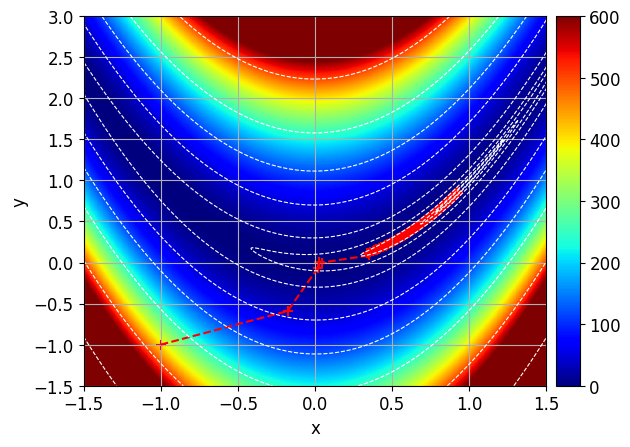

In [15]:
fig,ax=plt.subplots()
# im=plt.imshow(obj_ros_np.T,cmap='jet',vmin=0.0,vmax=600,extent=[-1.5,1.5,-1.0,3.0])
plt.scatter(x_smpld,y_smpld,color='red',s=50,marker="+")
plt.plot(x_smpld,y_smpld,"--",color='red')
im=plt.imshow(obj_ros_np.T,cmap='jet',vmin=0.0,vmax=600,extent=[1.5,-1.5,-1.5,3.0])
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
cs = plt.contour(obj_ros_np.T,levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],extent=[-1.5,1.5,3.0,-1.5],
                 colors="white",linewidths=(0.8,),linestyles=('--'))
plt.gca().invert_xaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax.set_aspect('auto')

In the third test, let's apply the BFGS algorithm to find the function's global minimum.

In [13]:
ParabStep = StepperPar() #Again we use the same parabolic stepper as before
BFGSsolver = LBFGS(Stop,stepper=ParabStep)
Ros_prob = Rosenbrock_prblm(x_init,y_init) #Resetting the problem
BFGSsolver.setDefaults(save_obj=True,save_model=True)
BFGSsolver.run(Ros_prob,verbose=True)
#Converting sampled points to arrays for plotting
x_smpld=[]
y_smpld=[]
for iter in range(len(BFGSsolver.model)):
    x_smpld.append(BFGSsolver.model[iter].getNdArray()[0])
    y_smpld.append(BFGSsolver.model[iter].getNdArray()[1])

##########################################################################################
Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm log file
Restart folder: /scratch/users/arustam/restart_2025-02-21T19-09-44.794898/
##########################################################################################

iter = 0000, obj = 4.04000e+02, gradnorm = 8.98e+02, feval = 1, geval = 1
Appplying inverse Hessian estimate
Done applying inverse Hessian estimate
First step-length value added to first Hessian inverse estimate!
iter = 0001, obj = 4.00632e+01, gradnorm = 1.33e+02, feval = 4, geval = 2
Appplying inverse Hessian estimate
Current inverse dot-products of BFGS estimation vectors [0.0013581063598393675]
Done applying inverse Hessian estimate
iter = 0002, obj = 1.47062e+00, gradnorm = 1.50e+01, feval = 7, geval = 3
Appplying inverse Hessian estimate
Current inverse dot-products of BFGS estimation vectors [0.0013581063598393675, 0.014949734009467506]
Done applying inverse Hessian e

The algorithm has precisely reached the global minimum in 24 iterations. We can clearly see that it is able to find an approximation of the local curvature of the objective function. In fact, it needs to sample very few points within the parabolic-shaped valley. 

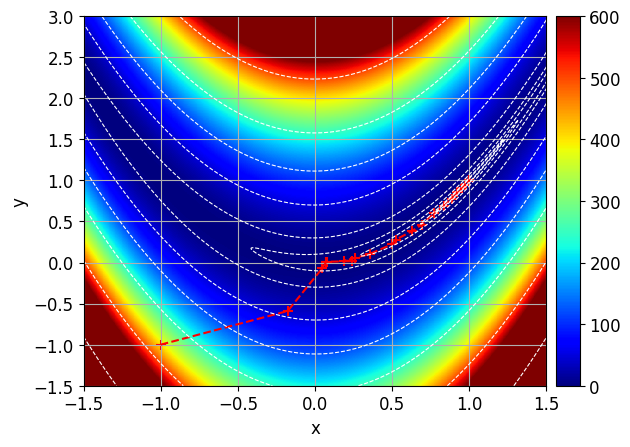

In [14]:
fig,ax=plt.subplots()
# im=plt.imshow(obj_ros_np.T,cmap='jet',vmin=0.0,vmax=600,extent=[-1.5,1.5,-1.0,3.0])
plt.scatter(x_smpld,y_smpld,color='red',s=50,marker="+")
plt.plot(x_smpld,y_smpld,"--",color='red')
im=plt.imshow(obj_ros_np.T,cmap='jet',vmin=0.0,vmax=600,extent=[1.5,-1.5,-1.5,3.0])
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
cs = plt.contour(obj_ros_np.T,levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],extent=[-1.5,1.5,3.0,-1.5],
                 colors="white",linewidths=(0.8,),linestyles=('--'))
plt.gca().invert_xaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax.set_aspect('auto')

Finally, let's test again the BFGS method but this time employing the line-search algorithm proposed by More and Thuente (1994). Their line-search method uses a backeting approach in which the strong Wolfe conditions are verified for the tested point. In this case, if these conditons are met, then the method was successful.

In [15]:
BFGSsolver = LBFGS(Stop)
Ros_prob = Rosenbrock_prblm(x_init,y_init) #Resetting the problem
BFGSsolver.setDefaults(save_obj=True,save_model=True)
BFGSsolver.run(Ros_prob,verbose=True)
#Converting sampled points to arrays for plotting
x_smpld=[]
y_smpld=[]
for iter in range(len(BFGSsolver.model)):
    x_smpld.append(BFGSsolver.model[iter].getNdArray()[0])
    y_smpld.append(BFGSsolver.model[iter].getNdArray()[1])

##########################################################################################
Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm log file
Restart folder: /scratch/users/arustam/restart_2025-02-21T19-10-30.331611/
##########################################################################################

iter = 0000, obj = 4.04000e+02, gradnorm = 8.98e+02, feval = 1, geval = 1
Appplying inverse Hessian estimate
Done applying inverse Hessian estimate
First step-length value added to first Hessian inverse estimate!
iter = 0001, obj = 1.36247e+02, gradnorm = 3.63e+02, feval = 2, geval = 2
Appplying inverse Hessian estimate
Current inverse dot-products of BFGS estimation vectors [0.004079706634548897]
Done applying inverse Hessian estimate
iter = 0002, obj = 5.53769e+01, gradnorm = 1.81e+02, feval = 3, geval = 3
Appplying inverse Hessian estimate
Current inverse dot-products of BFGS estimation vectors [0.004079706634548897, 0.017266903677173706]
Done applying inverse Hessian est

We can see that the algorithm has reached the global minimum in 36 iterations. However, since we employed a different stepping method, in which no parabolic interpolation is used during the optimization, the algorithm had to perfom only 41 objective function evaluations as opposed to 73 necessary by the BFGS method when the parabolic stepper was the line-search algorithm of choice.

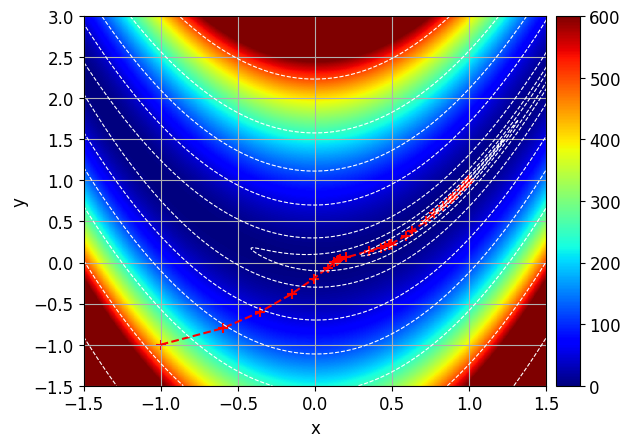

In [24]:
fig,ax=plt.subplots()
# im=plt.imshow(obj_ros_np.T,cmap='jet',vmin=0.0,vmax=600,extent=[-1.5,1.5,-1.0,3.0])
plt.scatter(x_smpld,y_smpld,color='red',s=50,marker="+")
plt.plot(x_smpld,y_smpld,"--",color='red')
im=plt.imshow(obj_ros_np.T,cmap='jet',vmin=0.0,vmax=600,extent=[1.5,-1.5,-1.5,3.0])
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
cs = plt.contour(obj_ros_np.T,levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],extent=[-1.5,1.5,3.0,-1.5],
                 colors="white",linewidths=(0.8,),linestyles=('--'))
plt.gca().invert_xaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax.set_aspect('auto')

In [18]:
# Lower and upper bounds and associtated vectors
xl = -1.2
yl = -1.2
xu = 1.2
yu = 2.0
minBound = Vec.vectorIC(np.array((xl, yl)))
maxBound = Vec.vectorIC(np.array((xu, yu)))
niter = 1000
Stop  = Stopper(niter=niter, tolg_proj=1e-32)
BFGSBsolver = LBFGSB(Stop, m_steps=10)
Ros_prob = Rosenbrock_prblm(x_init, y_init, minBound, maxBound) #Resetting the problem
BFGSBsolver.setDefaults(save_obj=True, save_model=True)
BFGSBsolver.run(Ros_prob,verbose=True)
#Converting sampled points to arrays for plotting
x_smpld = []
y_smpld = []
for i in range(len(BFGSBsolver.model)):
    x_smpld.append(BFGSBsolver.model[i].getNdArray()[0])
    y_smpld.append(BFGSBsolver.model[i].getNdArray()[1])
# Setting bounds for plotting
minBoundNd = minBound.getNdArray()
maxBoundNd = maxBound.getNdArray()
bounds_points_x = np.array([minBoundNd[0],minBoundNd[0],maxBoundNd[0],maxBoundNd[0],minBoundNd[0]])
bounds_points_y = np.array([minBoundNd[1],maxBoundNd[1],maxBoundNd[1],minBoundNd[1],minBoundNd[1]])

TypeError: __init__() missing 2 required positional arguments: 'stopper' and 'stepper'

In [7]:
import pyproximal as pp
from pyProxOperator import ProxOperatorExplicit
import pyStepper as Step

# # Lower and upper bounds and associtated vectors
xl = -1.2
yl = -1.2
xu = 0.7
yu = 2.0
minBound = np.array((xl, yl))
maxBound = np.array((xu, yu))

# xl = -.5
# yl = .5
# xu = 0.5
# yu = 1
# minBound = np.array((xl, yl))
# maxBound = np.array((xu, yu))

proxOp = ProxOperatorExplicit(pp.Box(minBound, maxBound))
# proxOp = ProxOperator(pp.L1())
# proxOp = ProxOperator(pp.EuclideanBall(np.array([0,0]), 0.2))
# proxOp = ProxOperator(pp.Log(1e-3))

niter = 1000
Stop  = Stopper(niter=niter, tolg_proj=1e-32)
solver = NLCG(Stop, proxOp=proxOp, beta_type='HZ')
Ros_prob = Rosenbrock_prblm(x_init, y_init) #Resetting the problem
solver.setDefaults(save_obj=True, save_model=True)
solver.run(Ros_prob,verbose=True)
#Converting sampled points to arrays for plotting
x_smpld = []
y_smpld = []
for i in range(len(solver.model)):
    x_smpld.append(solver.model[i].getNdArray()[0])
    y_smpld.append(solver.model[i].getNdArray()[1])
# Setting bounds for plotting
bounds_points_x = np.array([minBound[0],minBound[0],maxBound[0],maxBound[0],minBound[0]])
bounds_points_y = np.array([minBound[1],maxBound[1],maxBound[1],minBound[1],minBound[1]])

##########################################################################################
			NON-LINEAR CONJUGATE GRADIENT SOLVER log file
	Restart folder: /scratch/users/arustam/restart_2025-04-10T17-28-12.212873/
	Conjugate method used: HZ
##########################################################################################

iter = 0000, obj = 4.04000e+02, gradnorm = 8.98e+02, feval = 1, geval = 1
iter = 0001, obj = 4.00632e+01, gradnorm = 1.33e+02, feval = 4, geval = 2
iter = 0002, obj = 3.84404e+00, gradnorm = 3.80e+01, feval = 7, geval = 3
iter = 0003, obj = 6.53600e-01, gradnorm = 1.59e+00, feval = 10, geval = 4
iter = 0004, obj = 6.35361e-01, gradnorm = 1.57e+00, feval = 13, geval = 5
iter = 0005, obj = 5.76040e-01, gradnorm = 2.23e+00, feval = 16, geval = 6
iter = 0006, obj = 5.47205e-01, gradnorm = 4.76e+00, feval = 22, geval = 7
iter = 0007, obj = 3.99569e-01, gradnorm = 8.30e+00, feval = 25, geval = 8
iter = 0008, obj = 2.65074e-01, gradnorm = 1.19e+00, feval = 28, gev

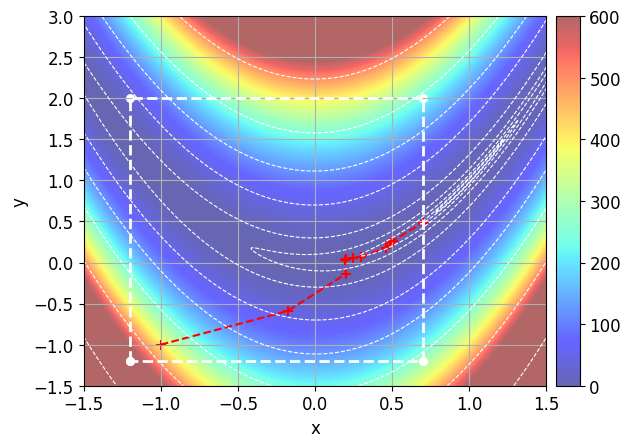

In [8]:
fig, ax = plt.subplots()
plt.scatter(x_smpld, y_smpld, color='red', s=50, marker="+")
plt.plot(x_smpld, y_smpld, "--", color='red')
plt.scatter(bounds_points_x, bounds_points_y, marker="o", color='w', s=30)
plt.plot(bounds_points_x, bounds_points_y, "--", color='w', linewidth=2)
im = plt.imshow(obj_ros.getNdArray().T, cmap='jet', alpha=.6,
                vmin=0.0, vmax=600, extent=[1.5,-1.5,-1.5,3.0])
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
cs = plt.contour(obj_ros.getNdArray().T,
                 levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],
                 extent=[-1.5,1.5,3.0,-1.5],
                 colors="white",
                 linewidths=(0.8,),
                 linestyles='--')
plt.gca().invert_xaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax.set_aspect('auto')
plt.show()

In [9]:
class Rosenbrock_prblm(Prblm.Problem):
	"""
	   Rosenbrock function inverse problem
	   f(x,y) = (1 - x)^2 + 100*(y -x^2)^2
	   m = [x y]'
	   res = objective function value
	"""

	def __init__(self,x_initial,y_initial, minBound=None, maxBound=None):
		"""Constructor of linear problem"""
		#Setting the bounds (if any)
		super(Rosenbrock_prblm,self).__init__(minBound, maxBound)
		#Setting initial model
		self.model  = Vec.vectorIC(np.array((x_initial,y_initial)))
		self.dmodel = self.model.clone()
		self.dmodel.zero()
		#Gradient vector
		self.grad=self.dmodel.clone()
		#Residual vector
		self.res = Vec.vectorIC(np.array((0.,)))
		self.prior = self.model.clone().zero()
		self.tau = 1
		#Dresidual vector
		self.dres=self.res.clone()
		#Setting default variables
		self.setDefaults()
		self.linear=False
		return

	def objf(self,model):
		"""Objective function computation"""
		m = model.getNdArray() #Getting ndArray of the model
		obj = self.res.arr[0]
		return obj
    

	def resf(self,model):
		"""Residual function"""
		m = model.getNdArray() #Getting ndArray of the model
		self.res.getNdArray()[0] = (1.0 - m[0])*(1.0 - m[0]) + 100.0 * (m[1] - m[0]*m[0]) * (m[1] - m[0]*m[0])
		self.res.getNdArray()[0] += 0.5*self.epsilon*self.epsilon * ((m[0] - self.prior[0])**2 + (m[1] - self.prior[1])**2)

		return self.res

	def gradf(self,model,res):
		"""Gradient computation"""
		m = model.getNdArray() #Getting ndArray of the model
		self.grad.getNdArray()[0] = - 2.0 * (1.0 - m[0]) - 400.0 * m[0] * (m[1] - m[0]*m[0])
		self.grad.getNdArray()[1] = 200.0 * (m[1] - m[0]*m[0])

		# Quadratic penalty gradient components
		self.grad.getNdArray()[0] += self.epsilon*self.epsilon * (m[0] - self.prior[0])
		self.grad.getNdArray()[1] += self.epsilon*self.epsilon * (m[1] - self.prior[1])

		return self.grad

In [10]:
from pyProxOperator import ProxOperatorImplicit
class ProxOperatorRosenbrock(ProxOperatorImplicit):

    def __init__(self, problem, solver, epsilon=1, warm=True):
        self.epsilon = epsilon
        self.problem = problem
        self.solver = solver
        self.warm = warm

In [80]:
from pySolverConstrained import ADMMsolver

niter = 10
Stop  = Stopper(niter=niter, tolg_proj=1e-32)
solver = NLCG(Stop, proxOp=None, beta_type='HZ')
Ros_prob = Rosenbrock_prblm(x_init, y_init) #Resetting the problem
solver.setDefaults(save_obj=True, save_model=True)

# # Lower and upper bounds and associtated vectors
xl = -1.2
yl = -1.2
xu = 0.7
yu = 2.0
minBound = np.array((xl, yl))
maxBound = np.array((xu, yu))

rho = 0.1

proxf = ProxOperatorRosenbrock(Ros_prob, solver)
proxg = ProxOperatorExplicit(pp.Box(minBound, maxBound))

admm = ADMMsolver(proxf, proxg, 10, rho=rho, rho_adjust_ratio=10, rho_decr=0.9, rho_incr=1.1, tol_prim=1e-12, tol_dual=1e-12)

admm.run(verbose=True)

					ADMM SOLVER log file

##########################################################################################
ADMM iter = 0, rho = 0.1, prim_res = 0.000000e+00, dual_res = 0.000000e+00
##########################################################################################

##########################################################################################
			NON-LINEAR CONJUGATE GRADIENT SOLVER log file
	Restart folder: /scratch/users/arustam/restart_2025-04-10T17-40-07.021234/
	Conjugate method used: HZ
##########################################################################################

iter = 00, obj = 4.04100e+02, gradnorm = 8.98e+02, feval = 1, geval = 1
iter = 01, obj = 2.01064e+01, gradnorm = 1.02e+02, feval = 4, geval = 2
iter = 02, obj = 8.57957e-01, gradnorm = 5.88e+00, feval = 7, geval = 3
iter = 03, obj = 7.81433e-01, gradnorm = 1.71e+00, feval = 10, geval = 4
iter = 04, obj = 7.67058e-01, gradnorm = 1.69e+00, feval = 13, geval = 5
iter = 05, obj = 6

In [81]:
#Converting sampled points to arrays for plotting
x_smpld = []
y_smpld = []
for i in range(len(solver.model)):
    x_smpld.append(solver.model[i].getNdArray()[0])
    y_smpld.append(solver.model[i].getNdArray()[1])
# Setting bounds for plotting
bounds_points_x = np.array([minBound[0],minBound[0],maxBound[0],maxBound[0],minBound[0]])
bounds_points_y = np.array([minBound[1],maxBound[1],maxBound[1],minBound[1],minBound[1]])

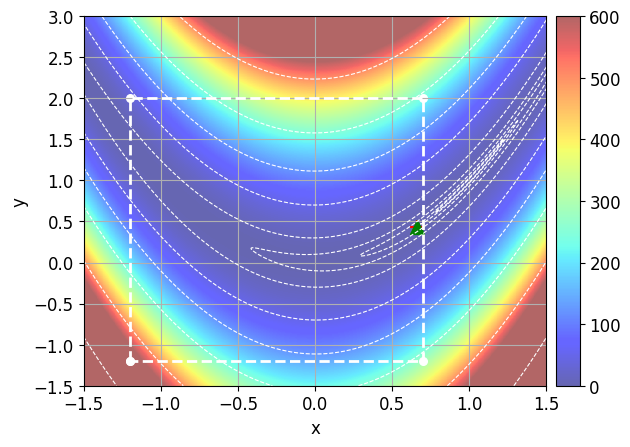

In [82]:
fig, ax = plt.subplots()
# plt.scatter(x_smpld, y_smpld, color='red', s=50, marker="+")
plt.scatter(admm.x[0], admm.x[1], color='red', s=100, marker="+")
plt.scatter(admm.z[0], admm.z[1], color='green', s=100, marker="^")

# plt.plot(x_smpld, y_smpld, "--", color='red')
plt.scatter(bounds_points_x, bounds_points_y, marker="o", color='w', s=30)
plt.plot(bounds_points_x, bounds_points_y, "--", color='w', linewidth=2)
im = plt.imshow(obj_ros.getNdArray().T, cmap='jet', alpha=.6,
                vmin=0.0, vmax=600, extent=[1.5,-1.5,-1.5,3.0])
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
cs = plt.contour(obj_ros.getNdArray().T,
                 levels=[0.05,0.1,0.5,2,10,50,125,250,500,1000],
                 extent=[-1.5,1.5,3.0,-1.5],
                 colors="white",
                 linewidths=(0.8,),
                 linestyles='--')
plt.gca().invert_xaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax.set_aspect('auto')
plt.show()

In [67]:
admm.x[:], admm.z[:], admm.u[:]

(array([0.6598205 , 0.43526324]),
 array([0.6598205 , 0.43526324]),
 array([0., 0.]))